In [1]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

import timm
import torch
import detectors
from torchvision import transforms
from utils import vis as vis

/home/kvergopoulos/miniconda3/envs/ffcv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from tqdm import tqdm

from data_utils.data_stats import *
from models.networks import get_model
from data_utils.dataloader import get_loader
from data_utils.dataset_to_beton import get_dataset

In [30]:
# define important parameters

dataset         = 'cifar10'               # One of cifar10, cifar100, stl10, imagenet or imagenet21
num_classes     = CLASS_DICT[dataset]
data_path       = '/scratch/ffcv'
model_path      = '/tmp/zooming_in_on_mlps/'
eval_batch_size = 32
data_resolution = 32 
checkpoint      = None


#model_type      = 'mlp'                   
#checkpoint      = 'in21k_cifar10'       
#architecture    = 'B_12-Wi_1024'        
#crop_resolution = 64            

model_type      = 'cnn'               
architecture    = 'resnet18_' + dataset                      
crop_resolution = 32

#model_type      = 'vit'                  
#architecture    = 'vit_small_patch16_224_' + dataset + '_v7.pth'        
#crop_resolution = 224 

In [31]:
def get_models_full(model_type, 
                    architecture, 
                    resolution  = crop_resolution, 
                    num_classes = CLASS_DICT[dataset], 
                    checkpoint  = checkpoint, 
                    model_path   = model_path):
    if model_type == 'mlp':
        model = get_model(architecture=architecture, resolution = resolution, 
                          num_classes=num_classes,checkpoint= checkpoint)
    elif model_type == 'cnn':
        model = timm.create_model(architecture, pretrained=True)
    elif model_type == 'vit':
        model = torch.load(os.path.join(model_path, architecture))
    return model

In [32]:
# load the models
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

In [33]:
loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

Loading /scratch/ffcv/cifar10/val_32.beton


Weights already downloaded
Load_state output <All keys matched successfully>
Loading /scratch/ffcv/cifar10/val_32.beton
probability for target class 0.6055338382720947
probability for target class 0.6220579147338867
probability for target class 0.634028971195221
probability for target class 0.6431203484535217
probability for target class 0.6502986550331116
probability for target class 0.6561561226844788
probability for target class 0.6610679030418396
probability for target class 0.6652808785438538
probability for target class 0.6689640283584595
probability for target class 0.6722363233566284
probability for target class 0.6751837730407715
probability for target class 0.6778658032417297
probability for target class 0.680332601070404
probability for target class 0.6826207637786865
probability for target class 0.6847571730613708
probability for target class 0.6867638230323792
probability for target class 0.6886612176895142
probability for target class 0.6904610395431519
probability for ta

/home/kvergopoulos/miniconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


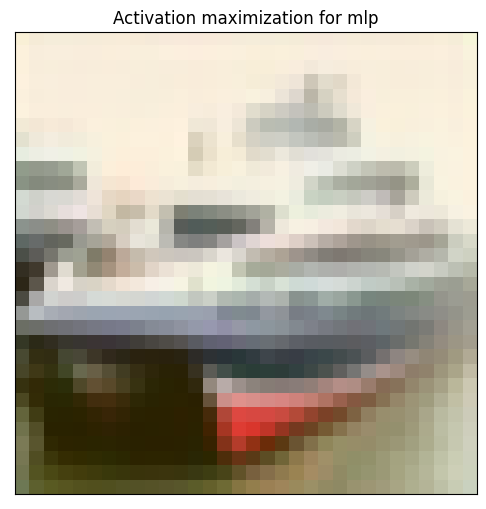

In [113]:
model_type      = 'mlp'                   
checkpoint      = 'in21k_cifar10'       
architecture    = 'B_12-Wi_1024'        
crop_resolution = 64 

# load the models
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

# for activation maximization. Start from total random noise or use
# an initial image instead
use_init_image = True

# generate image using activation maximization
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

if use_init_image == False:
    img   = None
    label = 0
else:
    label = label.item()

init_image1, synthetic_image1 = vis.generate_image(model        = model, 
                                     target_class = label,
                                     epochs       = 250, 
                                     min_prob     = 0.9, 
                                     lr           = .01, 
                                     weight_decay = 5e-2, 
                                     step_size    = 100, 
                                     gamma        = 0.9,
                                     noise_size   = crop_resolution,
                                     model_type   = model_type,
                                     img          = img,
                                     dataset      = dataset)


Loading /scratch/ffcv/cifar10/val_32.beton
probability for target class 0.9999675750732422


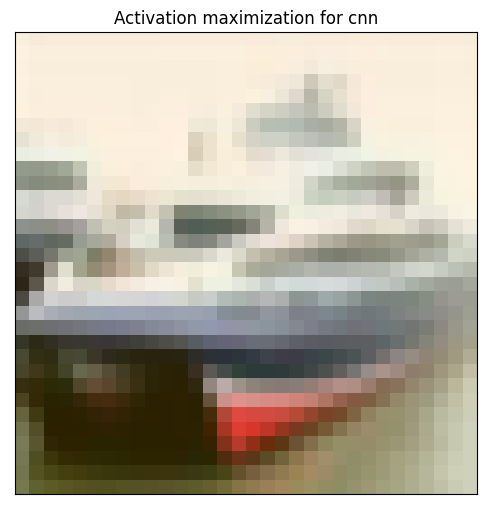

In [115]:
model_type      = 'cnn'               
architecture    = 'resnet18_' + dataset                      
crop_resolution = 32 

# load the model
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

# initialize loader
loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

# for activation maximization. Start from total random noise or use
# an initial image instead
use_init_image = True

# generate image using activation maximization
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

if use_init_image == False:
    img   = None
    label = 0
else:
    label = label.item()

init_image2, synthetic_image2 = vis.generate_image(model        = model, 
                                     target_class = label,
                                     epochs       = 250, 
                                     min_prob     = 0.9, 
                                     lr           = .01, 
                                     weight_decay = 5e-2, 
                                     step_size    = 100, 
                                     gamma        = 0.9,
                                     noise_size   = crop_resolution,
                                     model_type   = model_type,
                                     img          = img,
                                     dataset      = dataset)

Loading /scratch/ffcv/cifar10/val_32.beton
probability for target class 0.7589551210403442
probability for target class 0.902209460735321
probability for target class 0.9396027326583862
probability for target class 0.9532944560050964


/home/kvergopoulos/miniconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


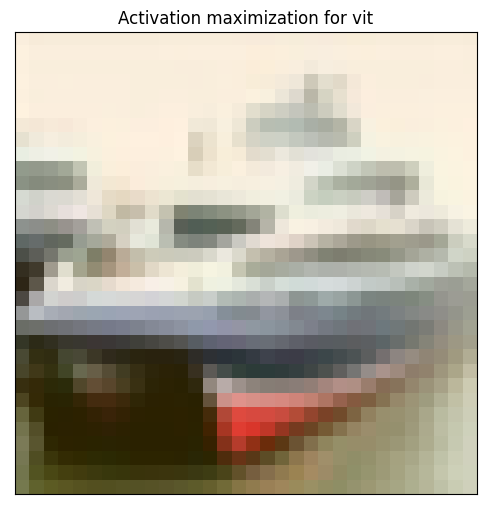

In [116]:
model_type      = 'vit'                  
architecture    = 'vit_small_patch16_224_' + dataset + '_v7.pth'        
crop_resolution = 224 

# load the model
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

# initialize loader
loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

# for activation maximization. Start from total random noise or use
# an initial image instead
use_init_image = True

# generate image using activation maximization
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

if use_init_image == False:
    img   = None
    label = 0
else:
    label = label.item()

init_image3, synthetic_image3 = vis.generate_image(model        = model, 
                                     target_class = label,
                                     epochs       = 150, 
                                     min_prob     = 0.9, 
                                     lr           = .01, 
                                     weight_decay = 5e-2, 
                                     step_size    = 100, 
                                     gamma        = 0.9,
                                     noise_size   = crop_resolution,
                                     model_type   = model_type,
                                     img          = img,
                                     dataset      = dataset)

In [117]:
print(f'norm original image mlp {torch.norm(init_image1 - synthetic_image1)}')
print(f'norm original image cnn {torch.norm(init_image2 - synthetic_image2)}')
print(f'norm original image vit {torch.norm(init_image3 - synthetic_image3)}')

norm original image mlp 0.705284059047699
norm original image mlp 0.0
norm original image mlp 0.08486096560955048


In [34]:
if model_type == 'cnn':
    modules = [model.conv1, model.layer1[1].conv1]
    #, model.layer2[1].conv1, 
if model_type == 'vit':
    modules = [ model.blocks[0].mlp.fc1,model.blocks[1].mlp.fc1]

In [40]:
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[31].unsqueeze(0)
label       = labels[31]
if model_type == 'mlp': img = torch.reshape(img, (1, -1))

0.39127054810523987
0.15481248497962952
0.14588338136672974
0.13773132860660553
0.1302756816148758
0.12343031913042068
0.11713805794715881
0.11134292185306549
0.10602163523435593
0.10113687068223953
0.09662671387195587
0.09246213734149933
0.08861091732978821
0.08503063768148422
0.081713005900383
0.07862193137407303
0.0757308229804039
0.0730348601937294
0.07052391022443771
0.06819348782300949
0.06601071357727051
0.06396263092756271
0.06205310299992561
0.06025789678096771
0.05856817960739136
0.05697586387395859
0.05547177046537399
0.05405323952436447
0.05271989852190018
0.05146203935146332
0.050283800810575485
0.04917718097567558
0.04813017323613167
0.04714542254805565
0.04621696472167969
0.045347973704338074
0.044527556747198105
0.04375627636909485
0.04302835091948509
0.042342912405729294
0.04169125109910965
0.041628703474998474
0.04156653210520744
0.04150480404496193
0.041443467140197754
0.041382402181625366
0.04132161661982536
0.04126109555363655
0.04120093956589699
0.0411411076784133

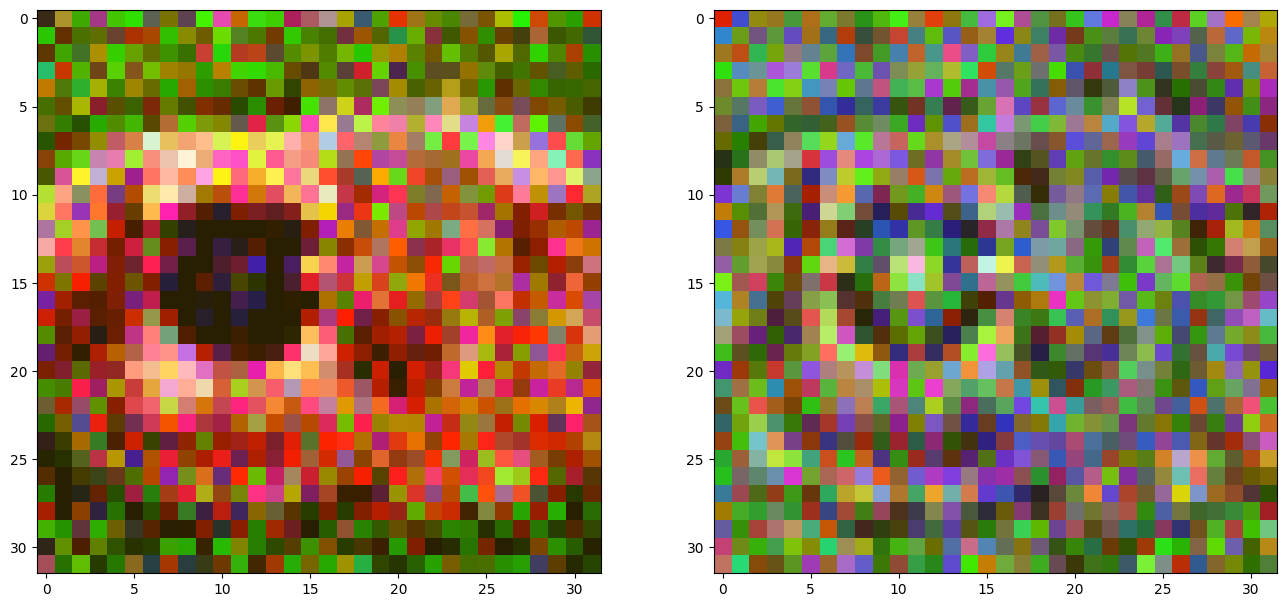

In [41]:
vis.feature_inversion(model      = model, 
                      modules    = modules, 
                      img        = img,
                      noise_size = crop_resolution,
                      epochs     = 150, 
                      lr         = 1000,
                      step_size  = 100,
                      gamma      = 0.6,
                      mu         = 1e-1,
                      device     = device)